## EDA - Manufacturing data

we can clearly see the missing values in workInprogress column for Finishing & Quality department,
which needs to be handled before model building.

In [47]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDRegressor, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
import warnings
warnings.filterwarnings('ignore')

Dataset loaded successfully. Shape: (1197, 15)
Columns: ['recordDate', 'fiscalQuarter', 'productionDept', 'dayOfWeek', 'team', 'plannedEfficiency', 'standardMinuteValue', 'workInProgress', 'overtimeMinutes', 'performanceBonus', 'idleMinutes', 'idleWorkers', 'styleChangeCount', 'workerCount', 'efficiencyScore']

Missing values per column:
recordDate               0
fiscalQuarter            0
productionDept           0
dayOfWeek                0
team                     0
plannedEfficiency        0
standardMinuteValue      0
workInProgress         506
overtimeMinutes          0
performanceBonus         0
idleMinutes              0
idleWorkers              0
styleChangeCount         0
workerCount              0
efficiencyScore          0
month                    0
day                      0
dtype: int64


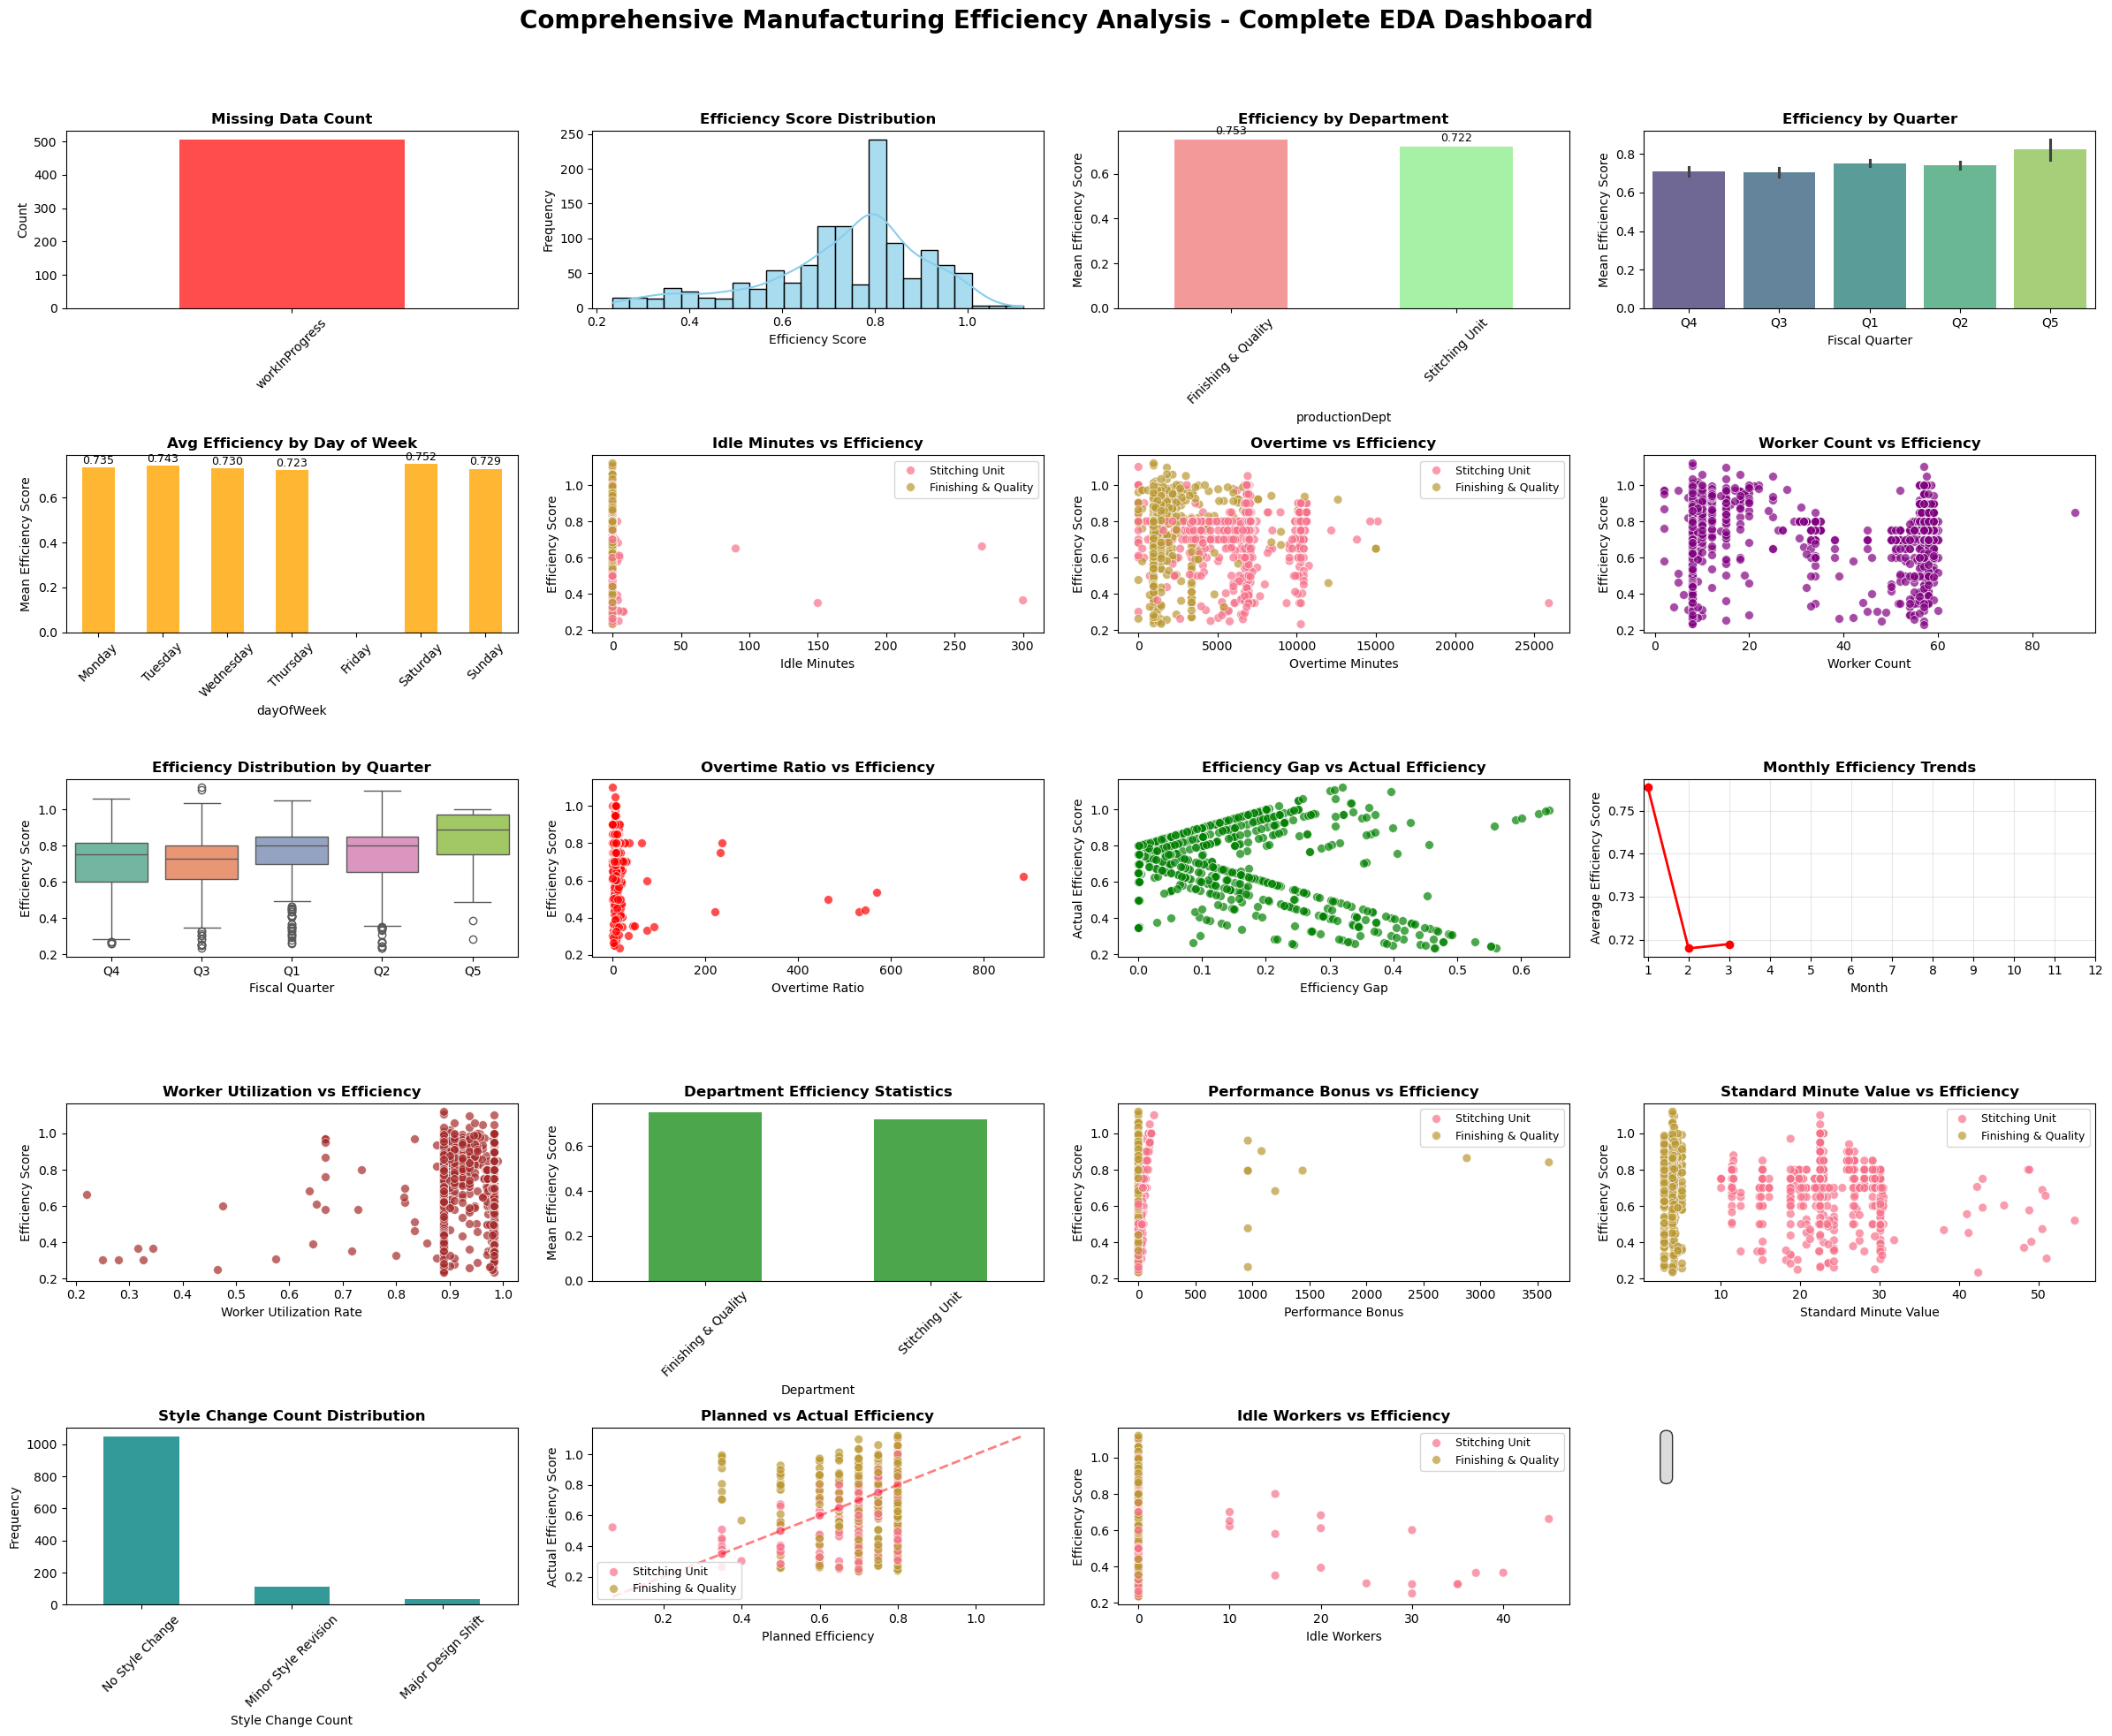

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better looking plots
plt.style.use('default')
sns.set_palette('husl')

# Load data with proper error handling

df = pd.read_csv('manufacturing_data.csv')
print(f"Dataset loaded successfully. Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")



# Data preprocessing
df['recordDate'] = pd.to_datetime(df['recordDate'], errors='coerce')
df['productionDept'] = df['productionDept'].str.strip()
df['month'] = df['recordDate'].dt.month
df['day'] = df['recordDate'].dt.day

# Check for missing values
print(f"\nMissing values per column:")
print(df.isnull().sum())

# Create comprehensive EDA visualization - ALL GRAPHS IN ONE FIGURE
fig = plt.figure(figsize=(24, 20))
fig.suptitle('Comprehensive Manufacturing Efficiency Analysis - Complete EDA Dashboard', fontsize=20, fontweight='bold', y=0.98)

# Create a grid layout for all plots
# Removed all manual spacing parameters (hspace, wspace, top, bottom, etc.)
gs = fig.add_gridspec(5, 4)

# 1. Missing Data Count (Top Left)
ax1 = fig.add_subplot(gs[0, 0])
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0]
if len(missing_data) > 0:
    missing_data.plot(kind='bar', ax=ax1, color='red', alpha=0.7)
    ax1.set_title('Missing Data Count', fontweight='bold', fontsize=12)
    ax1.tick_params(axis='x', rotation=45, labelsize=10)
    ax1.set_ylabel('Count', fontsize=10)
else:
    ax1.text(0.5, 0.5, 'No Missing Data', ha='center', va='center', transform=ax1.transAxes, fontsize=12)
    ax1.set_title('Missing Data Count', fontweight='bold', fontsize=12)

# 2. Efficiency Score Distribution (Top Center Left)
ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(df['efficiencyScore'], kde=True, ax=ax2, alpha=0.7, color='skyblue')
ax2.set_title('Efficiency Score Distribution', fontweight='bold', fontsize=12)
ax2.set_xlabel('Efficiency Score', fontsize=10)
ax2.set_ylabel('Frequency', fontsize=10)

# 3. Department Efficiency (Top Center Right)
ax3 = fig.add_subplot(gs[0, 2])
dept_eff = df.groupby('productionDept')['efficiencyScore'].mean()
bars = dept_eff.plot(kind='bar', ax=ax3, color=['lightcoral', 'lightgreen'], alpha=0.8)
ax3.set_title('Efficiency by Department', fontweight='bold', fontsize=12)
ax3.tick_params(axis='x', rotation=45, labelsize=10)
ax3.set_ylabel('Mean Efficiency Score', fontsize=10)
# Add value labels on bars
for i, v in enumerate(dept_eff.values):
    ax3.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

# 4. Quarterly Efficiency (Top Right)
ax4 = fig.add_subplot(gs[0, 3])
sns.barplot(x='fiscalQuarter', y='efficiencyScore', data=df, ax=ax4, palette='viridis', alpha=0.8)
ax4.set_title('Efficiency by Quarter', fontweight='bold', fontsize=12)
ax4.set_xlabel('Fiscal Quarter', fontsize=10)
ax4.set_ylabel('Mean Efficiency Score', fontsize=10)

# 5. Avg Efficiency by Day of Week (Second Row Left)
ax5 = fig.add_subplot(gs[1, 0])
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_eff = df.groupby('dayOfWeek')['efficiencyScore'].mean().reindex(day_order)
day_eff.plot(kind='bar', ax=ax5, color='orange', alpha=0.8)
ax5.set_title('Avg Efficiency by Day of Week', fontweight='bold', fontsize=12)
ax5.tick_params(axis='x', rotation=45, labelsize=10)
ax5.set_ylabel('Mean Efficiency Score', fontsize=10)
for i, v in enumerate(day_eff.values):
    ax5.text(i, v + 0.005, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

# 6. Idle Minutes vs Efficiency (Second Row Center Left)
ax6 = fig.add_subplot(gs[1, 1])
sns.scatterplot(x='idleMinutes', y='efficiencyScore', hue='productionDept', data=df, ax=ax6, alpha=0.7, s=50)
ax6.set_title('Idle Minutes vs Efficiency', fontweight='bold', fontsize=12)
ax6.set_xlabel('Idle Minutes', fontsize=10)
ax6.set_ylabel('Efficiency Score', fontsize=10)
ax6.legend(fontsize=9)

# 7. Overtime vs Efficiency (Second Row Center Right)
ax7 = fig.add_subplot(gs[1, 2])
sns.scatterplot(x='overtimeMinutes', y='efficiencyScore', hue='productionDept', data=df, ax=ax7, alpha=0.7, s=50)
ax7.set_title('Overtime vs Efficiency', fontweight='bold', fontsize=12)
ax7.set_xlabel('Overtime Minutes', fontsize=10)
ax7.set_ylabel('Efficiency Score', fontsize=10)
ax7.legend(fontsize=9)

# 8. Worker Count vs Efficiency (Second Row Right)
ax8 = fig.add_subplot(gs[1, 3])
sns.scatterplot(x='workerCount', y='efficiencyScore', data=df, ax=ax8, alpha=0.7, s=50, color='purple')
ax8.set_title('Worker Count vs Efficiency', fontweight='bold', fontsize=12)
ax8.set_xlabel('Worker Count', fontsize=10)
ax8.set_ylabel('Efficiency Score', fontsize=10)

# 9. Efficiency Box Plot by Quarter (Third Row Left)
ax9 = fig.add_subplot(gs[2, 0])
sns.boxplot(x='fiscalQuarter', y='efficiencyScore', data=df, ax=ax9, palette='Set2')
ax9.set_title('Efficiency Distribution by Quarter', fontweight='bold', fontsize=12)
ax9.set_xlabel('Fiscal Quarter', fontsize=10)
ax9.set_ylabel('Efficiency Score', fontsize=10)

# 10. Overtime Ratio vs Efficiency (Third Row Center Left)
ax10 = fig.add_subplot(gs[2, 1])
df['overtime_ratio'] = df['overtimeMinutes'] / (df['workInProgress'] + 1)
sns.scatterplot(x='overtime_ratio', y='efficiencyScore', data=df, alpha=0.7, ax=ax10, s=50, color='red')
ax10.set_title('Overtime Ratio vs Efficiency', fontweight='bold', fontsize=12)
ax10.set_xlabel('Overtime Ratio', fontsize=10)
ax10.set_ylabel('Efficiency Score', fontsize=10)

# 11. Efficiency Gap vs Actual Efficiency (Third Row Center Right)
ax11 = fig.add_subplot(gs[2, 2])
df['efficiencyGap'] = abs(df['plannedEfficiency'] - df['efficiencyScore'])
sns.scatterplot(x='efficiencyGap', y='efficiencyScore', data=df, alpha=0.7, ax=ax11, s=50, color='green')
ax11.set_title('Efficiency Gap vs Actual Efficiency', fontweight='bold', fontsize=12)
ax11.set_xlabel('Efficiency Gap', fontsize=10)
ax11.set_ylabel('Actual Efficiency Score', fontsize=10)

# 12. Monthly Efficiency Trends (Third Row Right)
ax12 = fig.add_subplot(gs[2, 3])
monthly_efficiency = df.groupby('month')['efficiencyScore'].mean()
monthly_efficiency.plot(kind='line', marker='o', ax=ax12, color='red', linewidth=2, markersize=6)
ax12.set_title('Monthly Efficiency Trends', fontweight='bold', fontsize=12)
ax12.set_xlabel('Month', fontsize=10)
ax12.set_ylabel('Average Efficiency Score', fontsize=10)
ax12.grid(True, alpha=0.3)
ax12.set_xticks(range(1, 13))

# 13. Worker Utilization vs Efficiency (Fourth Row Left)
ax13 = fig.add_subplot(gs[3, 0])
df['worker_utilization'] = (df['workerCount'] - df['idleWorkers']) / (df['workerCount'] + 1)
sns.scatterplot(x='worker_utilization', y='efficiencyScore', data=df, alpha=0.7, ax=ax13, s=50, color='brown')
ax13.set_title('Worker Utilization vs Efficiency', fontweight='bold', fontsize=12)
ax13.set_xlabel('Worker Utilization Rate', fontsize=10)
ax13.set_ylabel('Efficiency Score', fontsize=10)

# 14. Department Efficiency Statistics (Fourth Row Center Left)
ax14 = fig.add_subplot(gs[3, 1])
dept_stats = df.groupby('productionDept')['efficiencyScore'].agg(['mean', 'std', 'min', 'max'])
dept_stats['mean'].plot(kind='bar', ax=ax14, color='green', alpha=0.7)
ax14.set_title('Department Efficiency Statistics', fontweight='bold', fontsize=12)
ax14.set_xlabel('Department', fontsize=10)
ax14.set_ylabel('Mean Efficiency Score', fontsize=10)
ax14.tick_params(axis='x', rotation=45, labelsize=10)

# 15. Performance Bonus vs Efficiency (Fourth Row Center Right)
ax15 = fig.add_subplot(gs[3, 2])
sns.scatterplot(x='performanceBonus', y='efficiencyScore', hue='productionDept', data=df, ax=ax15, alpha=0.7, s=50)
ax15.set_title('Performance Bonus vs Efficiency', fontweight='bold', fontsize=12)
ax15.set_xlabel('Performance Bonus', fontsize=10)
ax15.set_ylabel('Efficiency Score', fontsize=10)
ax15.legend(fontsize=9)

# 16. Standard Minute Value vs Efficiency (Fourth Row Right)
ax16 = fig.add_subplot(gs[3, 3])
sns.scatterplot(x='standardMinuteValue', y='efficiencyScore', hue='productionDept', data=df, ax=ax16, alpha=0.7, s=50)
ax16.set_title('Standard Minute Value vs Efficiency', fontweight='bold', fontsize=12)
ax16.set_xlabel('Standard Minute Value', fontsize=10)
ax16.set_ylabel('Efficiency Score', fontsize=10)
ax16.legend(fontsize=9)

# 17. Style Change Count Distribution (Fifth Row Left)
ax17 = fig.add_subplot(gs[4, 0])
style_counts = df['styleChangeCount'].value_counts()
style_counts.plot(kind='bar', ax=ax17, color='teal', alpha=0.8)
ax17.set_title('Style Change Count Distribution', fontweight='bold', fontsize=12)
ax17.set_xlabel('Style Change Count', fontsize=10)
ax17.set_ylabel('Frequency', fontsize=10)
ax17.tick_params(axis='x', rotation=45, labelsize=10)

# 18. Planned vs Actual Efficiency (Fifth Row Center Left)
ax18 = fig.add_subplot(gs[4, 1])
sns.scatterplot(x='plannedEfficiency', y='efficiencyScore', hue='productionDept', data=df, ax=ax18, alpha=0.7, s=50)
ax18.set_title('Planned vs Actual Efficiency', fontweight='bold', fontsize=12)
ax18.set_xlabel('Planned Efficiency', fontsize=10)
ax18.set_ylabel('Actual Efficiency Score', fontsize=10)
ax18.legend(fontsize=9)
# Add diagonal line for perfect correlation
min_val = min(df['plannedEfficiency'].min(), df['efficiencyScore'].min())
max_val = max(df['plannedEfficiency'].max(), df['efficiencyScore'].max())
ax18.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5, linewidth=2)

# 19. Idle Workers vs Efficiency (Fifth Row Center Right)
ax19 = fig.add_subplot(gs[4, 2])
sns.scatterplot(x='idleWorkers', y='efficiencyScore', hue='productionDept', data=df, ax=ax19, alpha=0.7, s=50)
ax19.set_title('Idle Workers vs Efficiency', fontweight='bold', fontsize=12)
ax19.set_xlabel('Idle Workers', fontsize=10)
ax19.set_ylabel('Efficiency Score', fontsize=10)
ax19.legend(fontsize=9)

# 20. Dataset Summary Statistics (Fifth Row Right)
ax20 = fig.add_subplot(gs[4, 3])
ax20.axis('off')

ax20.text(0.05, 0.95, summary_text, transform=ax20.transAxes, fontsize=10,
          verticalalignment='top', fontfamily='monospace',
          bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8))

# --- THIS IS THE SECOND CHANGE ---
# Use tight_layout() with a rect parameter to automatically fix spacing
# The rect=[0, 0, 1, 0.95] leaves the top 5% of the figure for the suptitle.
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.savefig('comprehensive_manufacturing_eda.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


In [49]:
#del df['recordDate']

# Model Training for Stiching Unit Department.

In [50]:
import pandas as pd
import numpy as np
df_copy = df.copy(deep=True)
df_copy.head()

,recordDate,fiscalQuarter,productionDept,dayOfWeek,team,plannedEfficiency,standardMinuteValue,workInProgress,overtimeMinutes,performanceBonus,idleMinutes,idleWorkers,styleChangeCount,workerCount,efficiencyScore,month,day,overtime_ratio,efficiencyGap,worker_utilization
0,2015-02-24,Q4,Stitching Unit,Tuesday,Line-S1,0.6,22.53,708.0,5040,0,0.0,0,Minor Style Revision,42.0,0.268214,2,24,7.108604,0.331786,0.976744
1,2015-01-19,Q3,Stitching Unit,Monday,Line-F3,0.8,11.41,1028.0,4380,50,0.0,0,No Style Change,31.0,0.800359,1,19,4.256560,0.000359,0.968750
2,2015-01-06,Q1,Finishing & Quality,Tuesday,Line-C2,0.8,2.90,NaN,1440,0,0.0,0,No Style Change,8.0,0.681061,1,6,NaN,0.118939,0.888889
3,2015-02-24,Q4,Finishing & Quality,Tuesday,Line-S2,0.7,3.90,NaN,960,0,0.0,0,No Style Change,8.0,0.325000,2,24,NaN,0.375000,0.888889
4,2015-01-04,Q1,Finishing & Quality,Sunday,Line-C1,0.8,2.90,NaN,960,0,0.0,0,No Style Change,8.0,0.667604,1,4,NaN,0.132396,0.888889


In [51]:
df_0 = df_copy.dropna(subset=['workInProgress'])
df_0['productionDept'].value_counts()

productionDept
Stitching Unit    691
Name: count, dtype: int64

In [52]:
df_0.head()

,recordDate,fiscalQuarter,productionDept,dayOfWeek,team,plannedEfficiency,standardMinuteValue,workInProgress,overtimeMinutes,performanceBonus,idleMinutes,idleWorkers,styleChangeCount,workerCount,efficiencyScore,month,day,overtime_ratio,efficiencyGap,worker_utilization
0,2015-02-24,Q4,Stitching Unit,Tuesday,Line-S1,0.60,22.53,708.0,5040,0,0.0,0,Minor Style Revision,42.0,0.268214,2,24,7.108604,0.331786,0.976744
1,2015-01-19,Q3,Stitching Unit,Monday,Line-F3,0.80,11.41,1028.0,4380,50,0.0,0,No Style Change,31.0,0.800359,1,19,4.256560,0.000359,0.968750
5,2015-02-16,Q3,Stitching Unit,Monday,Line-F2,0.80,30.10,461.0,0,0,0.0,0,No Style Change,59.0,0.800980,2,16,0.000000,0.000980,0.983333
8,2015-01-24,Q4,Stitching Unit,Saturday,Line-C1,0.65,22.52,1295.0,10170,26,0.0,0,No Style Change,56.5,0.650417,1,24,7.847222,0.000417,0.982609
9,2015-03-05,Q1,Stitching Unit,Thursday,Line-Q1,0.75,18.79,1228.0,6240,45,0.0,0,No Style Change,52.0,0.750396,3,5,5.077299,0.000396,0.981132


In [53]:
df_0.describe()

,recordDate,plannedEfficiency,standardMinuteValue,workInProgress,overtimeMinutes,performanceBonus,idleMinutes,idleWorkers,workerCount,efficiencyScore,month,day,overtime_ratio,efficiencyGap,worker_utilization
count,691,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000
mean,2015-02-04 07:57:13.285093888,0.723980,23.245412,1190.465991,6508.205499,44.483357,1.264834,0.639653,52.445731,0.722013,1.722142,13.444284,12.801639,0.057867,0.969073
min,2015-01-01 00:00:00,0.070000,10.050000,7.000000,0.000000,0.000000,0.000000,0.000000,26.000000,0.233705,1.000000,1.000000,0.000000,0.000000,0.220339
25%,2015-01-18 00:00:00,0.700000,18.790000,774.500000,4560.000000,30.000000,0.000000,0.000000,52.000000,0.661470,1.000000,6.000000,4.483118,0.000274,0.981132
50%,2015-02-04 00:00:00,0.750000,22.520000,1039.000000,6840.000000,45.000000,0.000000,0.000000,57.000000,0.750608,2.000000,12.000000,6.305525,0.000618,0.982609
75%,2015-02-23 00:00:00,0.800000,28.080000,1252.500000,7200.000000,60.000000,0.000000,0.000000,58.000000,0.800402,2.000000,21.000000,9.048502,0.100020,0.983051
max,2015-03-11 00:00:00,0.800000,54.560000,23122.000000,25920.000000,138.000000,300.000000,45.000000,89.000000,1.100484,3.000000,31.000000,885.000000,0.492499,0.988889
std,NaN,0.102006,6.976497,1837.455001,2864.505604,27.596591,16.712923,4.283652,9.417353,0.154784,0.730943,8.583993,54.139272,0.094728,0.077091


Running this code as we have some rows with a space ahead of finishing and quality.

In [54]:
df['productionDept'] = df['productionDept'].str.strip()  # Removes leading and trailing spaces

## Encoding - categorical variables

In [55]:
# Ordinal Encoding - because they have fixed values.

L = LabelEncoder()

# Columns to encode
columns_to_encode_ord = ['fiscalQuarter', 'dayOfWeek', 'styleChangeCount']

for col in columns_to_encode_ord:
    df_0[col] = L.fit_transform(df_0[col])

In [56]:
# One Hot Encoding
columns_to_encode_ohe = ['productionDept', 'team']

df_0 = pd.get_dummies(df_0, columns = columns_to_encode_ohe, drop_first=True, dtype=int)
df_0.head()

,recordDate,fiscalQuarter,dayOfWeek,plannedEfficiency,standardMinuteValue,workInProgress,overtimeMinutes,performanceBonus,idleMinutes,idleWorkers,...,team_Line-F1,team_Line-F2,team_Line-F3,team_Line-P1,team_Line-P2,team_Line-Q1,team_Line-Q2,team_Line-S1,team_Line-S2,team_Line-S3
0,2015-02-24,3,4,0.60,22.53,708.0,5040,0,0.0,0,...,0,0,0,0,0,0,0,1,0,0
1,2015-01-19,2,0,0.80,11.41,1028.0,4380,50,0.0,0,...,0,0,1,0,0,0,0,0,0,0
5,2015-02-16,2,0,0.80,30.10,461.0,0,0,0.0,0,...,0,1,0,0,0,0,0,0,0,0
8,2015-01-24,3,1,0.65,22.52,1295.0,10170,26,0.0,0,...,0,0,0,0,0,0,0,0,0,0
9,2015-03-05,0,3,0.75,18.79,1228.0,6240,45,0.0,0,...,0,0,0,0,0,1,0,0,0,0


In [57]:
# Extracting the day and month from the recordDate column to take it as seperate features.
df_0['recordDate'] = pd.to_datetime(df_0['recordDate'])
df_0['month'] = df_0['recordDate'].dt.month
df_0['day'] = df_0['recordDate'].dt.day
df_0.head(10)

,recordDate,fiscalQuarter,dayOfWeek,plannedEfficiency,standardMinuteValue,workInProgress,overtimeMinutes,performanceBonus,idleMinutes,idleWorkers,...,team_Line-F1,team_Line-F2,team_Line-F3,team_Line-P1,team_Line-P2,team_Line-Q1,team_Line-Q2,team_Line-S1,team_Line-S2,team_Line-S3
0,2015-02-24,3,4,0.60,22.53,708.0,5040,0,0.0,0,...,0,0,0,0,0,0,0,1,0,0
1,2015-01-19,2,0,0.80,11.41,1028.0,4380,50,0.0,0,...,0,0,1,0,0,0,0,0,0,0
5,2015-02-16,2,0,0.80,30.10,461.0,0,0,0.0,0,...,0,1,0,0,0,0,0,0,0,0
8,2015-01-24,3,1,0.65,22.52,1295.0,10170,26,0.0,0,...,0,0,0,0,0,0,0,0,0,0
9,2015-03-05,0,3,0.75,18.79,1228.0,6240,45,0.0,0,...,0,0,0,0,0,1,0,0,0,0
10,2015-02-02,0,0,0.70,20.55,9792.0,6480,60,0.0,0,...,0,0,0,1,0,0,0,0,0,0
12,2015-01-04,0,2,0.80,26.16,1033.0,7080,63,0.0,0,...,0,0,0,0,0,0,0,1,0,0
14,2015-01-14,1,5,0.80,25.90,1150.0,10170,70,0.0,0,...,0,0,0,0,0,0,0,0,0,0
16,2015-02-12,1,3,0.80,22.52,1327.0,0,113,0.0,0,...,0,0,0,0,0,0,0,0,1,0
17,2015-02-14,1,1,0.60,11.41,1039.0,2280,23,0.0,0,...,0,0,0,1,0,0,0,0,0,0


In [58]:
df_0.columns.tolist()

['recordDate',
 'fiscalQuarter',
 'dayOfWeek',
 'plannedEfficiency',
 'standardMinuteValue',
 'workInProgress',
 'overtimeMinutes',
 'performanceBonus',
 'idleMinutes',
 'idleWorkers',
 'styleChangeCount',
 'workerCount',
 'efficiencyScore',
 'month',
 'day',
 'overtime_ratio',
 'efficiencyGap',
 'worker_utilization',
 'team_Line-C2',
 'team_Line-F1',
 'team_Line-F2',
 'team_Line-F3',
 'team_Line-P1',
 'team_Line-P2',
 'team_Line-Q1',
 'team_Line-Q2',
 'team_Line-S1',
 'team_Line-S2',
 'team_Line-S3']

## Feature Engineering

In [59]:
# Adding new Feature (workloadPerWorker) - how much workload each worker is doing in a team.
df_0['workloadPerWorker'] = df_0['standardMinuteValue'] * df_0['workInProgress'] / df_0['workerCount']
df_0['workloadPerWorker']

0       379.791429
1       378.370323
5       235.188136
8       516.166372
9       443.733077
           ...    
1183    448.029474
1185    527.190508
1187    472.984286
1191    156.512759
1195    226.515254
Name: workloadPerWorker, Length: 691, dtype: float64

In [60]:
# Adding new feature (overtimeperworker) - how much overtime each worker doing in a team.
df['overtimePerWorker'] = df['overtimeMinutes'] / df['workerCount']
df['overtimePerWorker']

0       120.000000
1       141.290323
2       180.000000
3       120.000000
4       120.000000
           ...    
1192    420.000000
1193    120.000000
1194      0.000000
1195      0.000000
1196    120.000000
Name: overtimePerWorker, Length: 1197, dtype: float64

In [61]:
df.isnull().sum().sort_values(ascending=False)

overtime_ratio         506
workInProgress         506
recordDate               0
idleWorkers              0
worker_utilization       0
efficiencyGap            0
day                      0
month                    0
efficiencyScore          0
workerCount              0
styleChangeCount         0
idleMinutes              0
fiscalQuarter            0
performanceBonus         0
overtimeMinutes          0
standardMinuteValue      0
plannedEfficiency        0
team                     0
dayOfWeek                0
productionDept           0
overtimePerWorker        0
dtype: int64

## Normalizaton of features

In [62]:
from sklearn.preprocessing import MinMaxScaler

features = [
    'fiscalQuarter',
    'standardMinuteValue',
    'workInProgress',
    'overtimeMinutes',
    'performanceBonus',
    'idleMinutes',
    'idleWorkers',
    'styleChangeCount',
    'workerCount',
    'month',
    'day'
]
S = MinMaxScaler()

df_0[features] = S.fit_transform(df_0[features])
df_0.head(10)

,recordDate,fiscalQuarter,dayOfWeek,plannedEfficiency,standardMinuteValue,workInProgress,overtimeMinutes,performanceBonus,idleMinutes,idleWorkers,...,team_Line-F2,team_Line-F3,team_Line-P1,team_Line-P2,team_Line-Q1,team_Line-Q2,team_Line-S1,team_Line-S2,team_Line-S3,workloadPerWorker
0,2015-02-24,0.75,4,0.60,0.280386,0.030327,0.194444,0.000000,0.0,0.0,...,0,0,0,0,0,0,1,0,0,379.791429
1,2015-01-19,0.50,0,0.80,0.030555,0.044170,0.168981,0.362319,0.0,0.0,...,0,1,0,0,0,0,0,0,0,378.370323
5,2015-02-16,0.50,0,0.80,0.450461,0.019641,0.000000,0.000000,0.0,0.0,...,1,0,0,0,0,0,0,0,0,235.188136
8,2015-01-24,0.75,1,0.65,0.280162,0.055721,0.392361,0.188406,0.0,0.0,...,0,0,0,0,0,0,0,0,0,516.166372
9,2015-03-05,0.00,3,0.75,0.196360,0.052823,0.240741,0.326087,0.0,0.0,...,0,0,0,0,1,0,0,0,0,443.733077
10,2015-02-02,0.00,0,0.70,0.235902,0.423318,0.250000,0.434783,0.0,0.0,...,0,0,1,0,0,0,0,0,0,3726.400000
12,2015-01-04,0.00,2,0.80,0.361941,0.044387,0.273148,0.456522,0.0,0.0,...,0,0,0,0,0,0,1,0,0,458.021695
14,2015-01-14,0.25,5,0.80,0.356100,0.049448,0.392361,0.507246,0.0,0.0,...,0,0,0,0,0,0,0,0,0,527.168142
16,2015-02-12,0.25,3,0.80,0.280162,0.057106,0.000000,0.818841,0.0,0.0,...,0,0,0,0,0,0,0,1,0,519.722435
17,2015-02-14,0.25,1,0.60,0.030555,0.044646,0.087963,0.166667,0.0,0.0,...,0,0,1,0,0,0,0,0,0,215.545273


## Storing all features in X and target variable in y

In [63]:
X = df_0.drop(columns=['efficiencyScore', 'recordDate', 'idleMinutes', 'idleWorkers'])
y = df_0['efficiencyScore']

In [64]:
X

,fiscalQuarter,dayOfWeek,plannedEfficiency,standardMinuteValue,workInProgress,overtimeMinutes,performanceBonus,styleChangeCount,workerCount,month,...,team_Line-F2,team_Line-F3,team_Line-P1,team_Line-P2,team_Line-Q1,team_Line-Q2,team_Line-S1,team_Line-S2,team_Line-S3,workloadPerWorker
0,0.75,4,0.60,0.280386,0.030327,0.194444,0.000000,0.5,0.253968,0.5,...,0,0,0,0,0,0,1,0,0,379.791429
1,0.50,0,0.80,0.030555,0.044170,0.168981,0.362319,1.0,0.079365,0.0,...,0,1,0,0,0,0,0,0,0,378.370323
5,0.50,0,0.80,0.450461,0.019641,0.000000,0.000000,1.0,0.523810,0.5,...,1,0,0,0,0,0,0,0,0,235.188136
8,0.75,1,0.65,0.280162,0.055721,0.392361,0.188406,1.0,0.484127,0.0,...,0,0,0,0,0,0,0,0,0,516.166372
9,0.00,3,0.75,0.196360,0.052823,0.240741,0.326087,1.0,0.412698,1.0,...,0,0,0,0,1,0,0,0,0,443.733077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183,0.50,4,0.70,0.280162,0.048756,0.326389,0.362319,1.0,0.492063,0.0,...,0,0,0,0,0,0,0,0,1,448.029474
1185,0.25,3,0.80,0.361941,0.051136,0.409722,0.543478,1.0,0.523810,0.0,...,0,0,0,0,0,0,1,0,0,527.190508
1187,0.25,2,0.60,0.458998,0.037292,0.259259,0.000000,0.5,0.476190,1.0,...,0,0,0,0,0,0,0,0,0,472.984286
1191,0.00,5,0.70,0.268030,0.017564,0.375000,0.289855,1.0,0.507937,0.0,...,1,0,0,0,0,0,0,0,0,156.512759


In [65]:
df_0.shape

(691, 30)

In [66]:
y

0       0.268214
1       0.800359
5       0.800980
8       0.650417
9       0.750396
          ...   
1183    0.750038
1185    0.850502
1187    0.600529
1191    0.700481
1195    0.611141
Name: efficiencyScore, Length: 691, dtype: float64

In [67]:
# Splitting the data into training and testing sets.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((552, 26), (139, 26), (552,), (139,))

## Linear Regression


In [68]:
# Training a Linear Regression model.
L = LinearRegression()
L.fit(X_train, y_train)

LinearRegression()

In [69]:
# efficiency score on test
# Test set metrics
y_pred_linear = L.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

# Train set metrics
y_pred_train_linear = L.predict(X_train)
mse_train_linear = mean_squared_error(y_train, y_pred_train_linear)
rmse_train_linear = np.sqrt(mse_train_linear)
mae_train_linear = mean_absolute_error(y_train, y_pred_train_linear)
r2_train_linear = r2_score(y_train, y_pred_train_linear)

print(f"{'='*60}")
print(f"Linear Regression - TEST SET")
print(f"{'='*60}")
print(f"MSE:  {mse_linear:.6f}")
print(f"RMSE: {rmse_linear:.6f}")
print(f"MAE:  {mae_linear:.6f}")
print(f"R²:   {r2_linear:.6f}")

print(f"\n{'='*60}")
print(f"Linear Regression - TRAIN SET")
print(f"{'='*60}")
print(f"MSE:  {mse_train_linear:.6f}")
print(f"RMSE: {rmse_train_linear:.6f}")
print(f"MAE:  {mae_train_linear:.6f}")
print(f"R²:   {r2_train_linear:.6f}")

print(f"\nOverfitting Gap (Train R² - Test R²): {r2_train_linear - r2_linear:.6f}")

Linear Regression - TEST SET
MSE:  0.003471
RMSE: 0.058915
MAE:  0.042396
R²:   0.803963

Linear Regression - TRAIN SET
MSE:  0.003058
RMSE: 0.055295
MAE:  0.038269
R²:   0.879860

Overfitting Gap (Train R² - Test R²): 0.075897


## Gradient Descent Linear regression

In [70]:
theta = np.zeros(X_train.shape[1])
lr = 0.01
iterations = 1001

for i in range(iterations):
    gradient = (1/len(X_train)) * X_train.T.dot(X_train.dot(theta) - y_train)
    theta -= lr * gradient

    if np.any(np.isnan(theta)): # Checking for NaN values
        print("Gradient descent diverged. Try reducing the learning rate.")
        break

Gradient descent diverged. Try reducing the learning rate.


In [71]:
y_pred_gradient = X_test.dot(theta)
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print(f"Mean Squared Error (Gradient Descent Linear Regression): {mse_linear:.5f}")
print(f"R-squared (Gradient Descent Linear Regression): {r2_linear:.5f}")

Mean Squared Error (Gradient Descent Linear Regression): 0.00347
R-squared (Gradient Descent Linear Regression): 0.80396


## Decision Tree

In [72]:
from sklearn.tree import DecisionTreeRegressor

DT = DecisionTreeRegressor(max_depth=5, random_state=42)
DT.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, random_state=42)

In [73]:
# Test set metrics
y_pred_decision = DT.predict(X_test)
mse_decision = mean_squared_error(y_test, y_pred_decision)
rmse_decision = np.sqrt(mse_decision)
mae_decision = mean_absolute_error(y_test, y_pred_decision)
r2_decision = r2_score(y_test, y_pred_decision)

# Train set metrics
y_pred_train_decision = DT.predict(X_train)
mse_train_decision = mean_squared_error(y_train, y_pred_train_decision)
rmse_train_decision = np.sqrt(mse_train_decision)
mae_train_decision = mean_absolute_error(y_train, y_pred_train_decision)
r2_train_decision = r2_score(y_train, y_pred_train_decision)


print(f"Decision Tree - TEST SET")

print(f"MSE:  {mse_decision:.6f}")
print(f"RMSE: {rmse_decision:.6f}")
print(f"MAE:  {mae_decision:.6f}")
print(f"R²:   {r2_decision:.6f}")


print(f"Decision Tree - TRAIN SET")

print(f"MSE:  {mse_train_decision:.6f}")
print(f"RMSE: {rmse_train_decision:.6f}")
print(f"MAE:  {mae_train_decision:.6f}")
print(f"R²:   {r2_train_decision:.6f}")

print(f"\nOverfitting Gap (Train R² - Test R²): {r2_train_decision - r2_decision:.6f}")

Decision Tree - TEST SET
MSE:  0.003521
RMSE: 0.059339
MAE:  0.034961
R²:   0.801133
Decision Tree - TRAIN SET
MSE:  0.001213
RMSE: 0.034822
MAE:  0.025777
R²:   0.952355

Overfitting Gap (Train R² - Test R²): 0.151222


## Random Forest Regressor

In [74]:
# implementation of Ramdom Forest Regressor
RF = RandomForestRegressor()
RF.fit(X_train, y_train)

# Test set metrics
y_pred_random = RF.predict(X_test)
mse_random = mean_squared_error(y_test, y_pred_random)
rmse_random = np.sqrt(mse_random)
mae_random = mean_absolute_error(y_test, y_pred_random)
r2_random = r2_score(y_test, y_pred_random)

# Train set metrics
y_pred_train_random = RF.predict(X_train)
mse_train_random = mean_squared_error(y_train, y_pred_train_random)
rmse_train_random = np.sqrt(mse_train_random)
mae_train_random = mean_absolute_error(y_train, y_pred_train_random)
r2_train_random = r2_score(y_train, y_pred_train_random)

print(f"{'='*60}")
print(f"Random Forest - TEST SET")
print(f"{'='*60}")
print(f"MSE:  {mse_random:.6f}")
print(f"RMSE: {rmse_random:.6f}")
print(f"MAE:  {mae_random:.6f}")
print(f"R²:   {r2_random:.6f}")


print(f"Random Forest - TRAIN SET")

print(f"MSE:  {mse_train_random:.6f}")
print(f"RMSE: {rmse_train_random:.6f}")
print(f"MAE:  {mae_train_random:.6f}")
print(f"R²:   {r2_train_random:.6f}")

print(f"\nOverfitting Gap (Train R² - Test R²): {r2_train_random - r2_random:.6f}")

Random Forest - TEST SET
MSE:  0.001726
RMSE: 0.041544
MAE:  0.016929
R²:   0.902524
Random Forest - TRAIN SET
MSE:  0.000220
RMSE: 0.014824
MAE:  0.005801
R²:   0.991365

Overfitting Gap (Train R² - Test R²): 0.088841


# Model Training for Finishing and Quality Department

In [75]:
import pandas as pd
import numpy as np
df = pd.read_csv('manufacturing_data.csv')
df.head()

,recordDate,fiscalQuarter,productionDept,dayOfWeek,team,plannedEfficiency,standardMinuteValue,workInProgress,overtimeMinutes,performanceBonus,idleMinutes,idleWorkers,styleChangeCount,workerCount,efficiencyScore
0,2/24/2015,Q4,Stitching Unit,Tuesday,Line-S1,0.6,22.53,708.0,5040,0,0.0,0,Minor Style Revision,42.0,0.268214
1,1/19/2015,Q3,Stitching Unit,Monday,Line-F3,0.8,11.41,1028.0,4380,50,0.0,0,No Style Change,31.0,0.800359
2,1/6/2015,Q1,Finishing & Quality,Tuesday,Line-C2,0.8,2.90,NaN,1440,0,0.0,0,No Style Change,8.0,0.681061
3,2/24/2015,Q4,Finishing & Quality,Tuesday,Line-S2,0.7,3.90,NaN,960,0,0.0,0,No Style Change,8.0,0.325000
4,1/4/2015,Q1,Finishing & Quality,Sunday,Line-C1,0.8,2.90,NaN,960,0,0.0,0,No Style Change,8.0,0.667604


In [76]:
df['productionDept'] = df['productionDept'].str.strip()  # Removes leading and trailing spaces

In [77]:
df = df[df['productionDept']!='Stitching Unit']
df.head()

,recordDate,fiscalQuarter,productionDept,dayOfWeek,team,plannedEfficiency,standardMinuteValue,workInProgress,overtimeMinutes,performanceBonus,idleMinutes,idleWorkers,styleChangeCount,workerCount,efficiencyScore
2,1/6/2015,Q1,Finishing & Quality,Tuesday,Line-C2,0.8,2.90,NaN,1440,0,0.0,0,No Style Change,8.0,0.681061
3,2/24/2015,Q4,Finishing & Quality,Tuesday,Line-S2,0.7,3.90,NaN,960,0,0.0,0,No Style Change,8.0,0.325000
4,1/4/2015,Q1,Finishing & Quality,Sunday,Line-C1,0.8,2.90,NaN,960,0,0.0,0,No Style Change,8.0,0.667604
6,2/26/2015,Q4,Finishing & Quality,Thursday,Line-S1,0.5,3.94,NaN,3360,0,0.0,0,No Style Change,8.0,0.768847
7,2/28/2015,Q4,Finishing & Quality,Saturday,Line-S1,0.5,3.94,NaN,3360,0,0.0,0,No Style Change,8.0,0.768847


In [78]:
df['productionDept'].value_counts()

productionDept
Finishing & Quality    506
Name: count, dtype: int64

In [79]:
df.describe()

,plannedEfficiency,standardMinuteValue,workInProgress,overtimeMinutes,performanceBonus,idleMinutes,idleWorkers,workerCount,efficiencyScore
count,506.000000,506.000000,0.0,506.000000,506.000000,506.0,506.0,506.000000,506.000000
mean,0.737352,3.887036,NaN,1917.154150,29.644269,0.0,0.0,10.252964,0.752951
std,0.091512,0.594110,NaN,1776.698408,244.130042,0.0,0.0,4.007819,0.197021
min,0.350000,2.900000,NaN,0.000000,0.000000,0.0,0.0,2.000000,0.235795
25%,0.700000,3.900000,NaN,960.000000,0.000000,0.0,0.0,8.000000,0.631606
50%,0.750000,3.940000,NaN,1440.000000,0.000000,0.0,0.0,8.000000,0.805909
75%,0.800000,4.150000,NaN,1920.000000,0.000000,0.0,0.0,11.750000,0.906364
max,0.800000,5.130000,NaN,15000.000000,3600.000000,0.0,0.0,28.000000,1.120437


## Encoding categorical variables

In [80]:
L = LabelEncoder()

# Columns to encode
columns_to_encode_ord = ['productionDept', 'team']

for col in columns_to_encode_ord:
    df[col] = L.fit_transform(df[col])

In [81]:
columns_to_encode_ohe = ['fiscalQuarter', 'dayOfWeek', 'styleChangeCount']

df = pd.get_dummies(df, columns = columns_to_encode_ohe, drop_first=True, dtype=int)
df.head()

,recordDate,productionDept,team,plannedEfficiency,standardMinuteValue,workInProgress,overtimeMinutes,performanceBonus,idleMinutes,idleWorkers,...,efficiencyScore,fiscalQuarter_Q2,fiscalQuarter_Q3,fiscalQuarter_Q4,fiscalQuarter_Q5,dayOfWeek_Saturday,dayOfWeek_Sunday,dayOfWeek_Thursday,dayOfWeek_Tuesday,dayOfWeek_Wednesday
2,1/6/2015,0,1,0.8,2.90,NaN,1440,0,0.0,0,...,0.681061,0,0,0,0,0,0,0,1,0
3,2/24/2015,0,10,0.7,3.90,NaN,960,0,0.0,0,...,0.325000,0,0,1,0,0,0,0,1,0
4,1/4/2015,0,0,0.8,2.90,NaN,960,0,0.0,0,...,0.667604,0,0,0,0,0,1,0,0,0
6,2/26/2015,0,9,0.5,3.94,NaN,3360,0,0.0,0,...,0.768847,0,0,1,0,0,0,1,0,0
7,2/28/2015,0,9,0.5,3.94,NaN,3360,0,0.0,0,...,0.768847,0,0,1,0,1,0,0,0,0


In [82]:
df['recordDate'] = pd.to_datetime(df['recordDate'])
df['month'] = df['recordDate'].dt.month
df['day'] = df['recordDate'].dt.day
df.head(10)

,recordDate,productionDept,team,plannedEfficiency,standardMinuteValue,workInProgress,overtimeMinutes,performanceBonus,idleMinutes,idleWorkers,...,fiscalQuarter_Q3,fiscalQuarter_Q4,fiscalQuarter_Q5,dayOfWeek_Saturday,dayOfWeek_Sunday,dayOfWeek_Thursday,dayOfWeek_Tuesday,dayOfWeek_Wednesday,month,day
2,2015-01-06,0,1,0.80,2.90,NaN,1440,0,0.0,0,...,0,0,0,0,0,0,1,0,1,6
3,2015-02-24,0,10,0.70,3.90,NaN,960,0,0.0,0,...,0,1,0,0,0,0,1,0,2,24
4,2015-01-04,0,0,0.80,2.90,NaN,960,0,0.0,0,...,0,0,0,0,1,0,0,0,1,4
6,2015-02-26,0,9,0.50,3.94,NaN,3360,0,0.0,0,...,0,1,0,0,0,1,0,0,2,26
7,2015-02-28,0,9,0.50,3.94,NaN,3360,0,0.0,0,...,0,1,0,1,0,0,0,0,2,28
11,2015-01-04,0,2,0.80,3.94,NaN,6600,0,0.0,0,...,0,0,0,0,1,0,0,0,1,4
13,2015-02-19,0,11,0.50,5.13,NaN,2880,0,0.0,0,...,1,0,0,0,0,1,0,0,2,19
15,2015-01-11,0,11,0.75,4.15,NaN,1440,0,0.0,0,...,0,0,0,0,1,0,0,0,1,11
22,2015-02-08,0,9,0.80,3.94,NaN,1200,0,0.0,0,...,0,0,0,0,1,0,0,0,2,8
23,2015-02-22,0,9,0.80,3.94,NaN,2880,0,0.0,0,...,0,1,0,0,1,0,0,0,2,22


In [83]:
df.columns.tolist()

['recordDate',
 'productionDept',
 'team',
 'plannedEfficiency',
 'standardMinuteValue',
 'workInProgress',
 'overtimeMinutes',
 'performanceBonus',
 'idleMinutes',
 'idleWorkers',
 'workerCount',
 'efficiencyScore',
 'fiscalQuarter_Q2',
 'fiscalQuarter_Q3',
 'fiscalQuarter_Q4',
 'fiscalQuarter_Q5',
 'dayOfWeek_Saturday',
 'dayOfWeek_Sunday',
 'dayOfWeek_Thursday',
 'dayOfWeek_Tuesday',
 'dayOfWeek_Wednesday',
 'month',
 'day']

In [84]:
df = df.drop('workInProgress', axis=1)

## Feature Engineering

In [85]:
df['overtimePerWorker'] = df['overtimeMinutes'] / df['workerCount']
df['overtimePerWorker']

2       180.0
3       120.0
4       120.0
6       420.0
7       420.0
        ...  
1190    120.0
1192    420.0
1193    120.0
1194      0.0
1196    120.0
Name: overtimePerWorker, Length: 506, dtype: float64

In [86]:
df['bonusPerMinute'] = df['performanceBonus']/df['standardMinuteValue']
df['bonusPerMinute']

2         0.000000
3         0.000000
4         0.000000
6         0.000000
7         0.000000
           ...    
1190      0.000000
1192      0.000000
1193      0.000000
1194    730.964467
1196      0.000000
Name: bonusPerMinute, Length: 506, dtype: float64

In [87]:
df.isnull().sum().sort_values(ascending=False)

recordDate             0
productionDept         0
overtimePerWorker      0
day                    0
month                  0
dayOfWeek_Wednesday    0
dayOfWeek_Tuesday      0
dayOfWeek_Thursday     0
dayOfWeek_Sunday       0
dayOfWeek_Saturday     0
fiscalQuarter_Q5       0
fiscalQuarter_Q4       0
fiscalQuarter_Q3       0
fiscalQuarter_Q2       0
efficiencyScore        0
workerCount            0
idleWorkers            0
idleMinutes            0
performanceBonus       0
overtimeMinutes        0
standardMinuteValue    0
plannedEfficiency      0
team                   0
bonusPerMinute         0
dtype: int64

## Feature Scaling

In [88]:
features = [
    'standardMinuteValue',
    'overtimeMinutes',
    'performanceBonus',
    'idleWorkers',
    'workerCount',
    'month',
    'day',
    'bonusPerMinute'
]
S = MinMaxScaler()

df[features] = S.fit_transform(df[features])
df.head(10)

,recordDate,productionDept,team,plannedEfficiency,standardMinuteValue,overtimeMinutes,performanceBonus,idleMinutes,idleWorkers,workerCount,...,fiscalQuarter_Q5,dayOfWeek_Saturday,dayOfWeek_Sunday,dayOfWeek_Thursday,dayOfWeek_Tuesday,dayOfWeek_Wednesday,month,day,overtimePerWorker,bonusPerMinute
2,2015-01-06,0,1,0.80,0.000000,0.096,0.0,0.0,0.0,0.230769,...,0,0,0,0,1,0,0.0,0.166667,180.0,0.0
3,2015-02-24,0,10,0.70,0.448430,0.064,0.0,0.0,0.0,0.230769,...,0,0,0,0,1,0,0.5,0.766667,120.0,0.0
4,2015-01-04,0,0,0.80,0.000000,0.064,0.0,0.0,0.0,0.230769,...,0,0,1,0,0,0,0.0,0.100000,120.0,0.0
6,2015-02-26,0,9,0.50,0.466368,0.224,0.0,0.0,0.0,0.230769,...,0,0,0,1,0,0,0.5,0.833333,420.0,0.0
7,2015-02-28,0,9,0.50,0.466368,0.224,0.0,0.0,0.0,0.230769,...,0,1,0,0,0,0,0.5,0.900000,420.0,0.0
11,2015-01-04,0,2,0.80,0.466368,0.440,0.0,0.0,0.0,0.692308,...,0,0,1,0,0,0,0.0,0.100000,330.0,0.0
13,2015-02-19,0,11,0.50,1.000000,0.192,0.0,0.0,0.0,0.384615,...,0,0,0,1,0,0,0.5,0.600000,240.0,0.0
15,2015-01-11,0,11,0.75,0.560538,0.096,0.0,0.0,0.0,0.230769,...,0,0,1,0,0,0,0.0,0.333333,180.0,0.0
22,2015-02-08,0,9,0.80,0.466368,0.080,0.0,0.0,0.0,0.307692,...,0,0,1,0,0,0,0.5,0.233333,120.0,0.0
23,2015-02-22,0,9,0.80,0.466368,0.192,0.0,0.0,0.0,0.384615,...,0,0,1,0,0,0,0.5,0.700000,240.0,0.0


In [89]:
X = df.drop(columns=['efficiencyScore', 'recordDate', 'idleMinutes'])
y = df['efficiencyScore']

# Note: Categorical columns are already encoded in earlier cells
# (fiscalQuarter, productionDept, dayOfWeek, team, styleChangeCount)

print('Features:')
print(X.columns.tolist())
print(f'Total features: {len(X.columns)}')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

Features:
['productionDept', 'team', 'plannedEfficiency', 'standardMinuteValue', 'overtimeMinutes', 'performanceBonus', 'idleWorkers', 'workerCount', 'fiscalQuarter_Q2', 'fiscalQuarter_Q3', 'fiscalQuarter_Q4', 'fiscalQuarter_Q5', 'dayOfWeek_Saturday', 'dayOfWeek_Sunday', 'dayOfWeek_Thursday', 'dayOfWeek_Tuesday', 'dayOfWeek_Wednesday', 'month', 'day', 'overtimePerWorker', 'bonusPerMinute']
Total features: 21


((404, 21), (102, 21), (404,), (102,))

# Model Training for Finishing & Quality Department

## Linear Regression

In [90]:
L = LinearRegression()
L.fit(X_train, y_train)

# Test set metrics
y_pred_linear = L.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

# Train set metrics
y_pred_train_linear = L.predict(X_train)
mse_train_linear = mean_squared_error(y_train, y_pred_train_linear)
rmse_train_linear = np.sqrt(mse_train_linear)
mae_train_linear = mean_absolute_error(y_train, y_pred_train_linear)
r2_train_linear = r2_score(y_train, y_pred_train_linear)

print(f"{'='*60}")
print(f"Linear Regression (Section 2) - TEST SET")
print(f"{'='*60}")
print(f"MSE:  {mse_linear:.6f}")
print(f"RMSE: {rmse_linear:.6f}")
print(f"MAE:  {mae_linear:.6f}")
print(f"R²:   {r2_linear:.6f}")

print(f"Linear Regression (Section 2) - TRAIN SET")

print(f"MSE:  {mse_train_linear:.6f}")
print(f"RMSE: {rmse_train_linear:.6f}")
print(f"MAE:  {mae_train_linear:.6f}")
print(f"R²:   {r2_train_linear:.6f}")

print(f"\nOverfitting Gap (Train R² - Test R²): {r2_train_linear - r2_linear:.6f}")

Linear Regression (Section 2) - TEST SET
MSE:  0.026289
RMSE: 0.162138
MAE:  0.127010
R²:   0.265369
Linear Regression (Section 2) - TRAIN SET
MSE:  0.031492
RMSE: 0.177461
MAE:  0.136935
R²:   0.200725

Overfitting Gap (Train R² - Test R²): -0.064644


## Decision Tree Regressor

In [91]:
DT = DecisionTreeRegressor(max_depth=5, random_state=42)
DT.fit(X_train, y_train)

# Test set metrics
y_pred_decision = DT.predict(X_test)
mse_decision = mean_squared_error(y_test, y_pred_decision)
rmse_decision = np.sqrt(mse_decision)
mae_decision = mean_absolute_error(y_test, y_pred_decision)
r2_decision = r2_score(y_test, y_pred_decision)

# Train set metrics
y_pred_train_decision = DT.predict(X_train)
mse_train_decision = mean_squared_error(y_train, y_pred_train_decision)
rmse_train_decision = np.sqrt(mse_train_decision)
mae_train_decision = mean_absolute_error(y_train, y_pred_train_decision)
r2_train_decision = r2_score(y_train, y_pred_train_decision)


print(f"Decision Tree (Section 2) - TEST SET")

print(f"MSE:  {mse_decision:.6f}")
print(f"RMSE: {rmse_decision:.6f}")
print(f"MAE:  {mae_decision:.6f}")
print(f"R²:   {r2_decision:.6f}")


print(f"Decision Tree (Section 2) - TRAIN SET")

print(f"MSE:  {mse_train_decision:.6f}")
print(f"RMSE: {rmse_train_decision:.6f}")
print(f"MAE:  {mae_train_decision:.6f}")
print(f"R²:   {r2_train_decision:.6f}")

print(f"\nOverfitting Gap (Train R² - Test R²): {r2_train_decision - r2_decision:.6f}")

Decision Tree (Section 2) - TEST SET
MSE:  0.034827
RMSE: 0.186620
MAE:  0.133972
R²:   0.026771
Decision Tree (Section 2) - TRAIN SET
MSE:  0.020740
RMSE: 0.144015
MAE:  0.105345
R²:   0.473610

Overfitting Gap (Train R² - Test R²): 0.446839


## Random Forest Regressor


In [92]:
RF = RandomForestRegressor()
RF.fit(X_train, y_train)

# Test set metrics
y_pred_random = RF.predict(X_test)
mse_random = mean_squared_error(y_test, y_pred_random)
rmse_random = np.sqrt(mse_random)
mae_random = mean_absolute_error(y_test, y_pred_random)
r2_random = r2_score(y_test, y_pred_random)

# Train set metrics
y_pred_train_random = RF.predict(X_train)
mse_train_random = mean_squared_error(y_train, y_pred_train_random)
rmse_train_random = np.sqrt(mse_train_random)
mae_train_random = mean_absolute_error(y_train, y_pred_train_random)
r2_train_random = r2_score(y_train, y_pred_train_random)


print(f"Random Forest (Section 2) - TEST SET")

print(f"MSE:  {mse_random:.6f}")
print(f"RMSE: {rmse_random:.6f}")
print(f"MAE:  {mae_random:.6f}")
print(f"R²:   {r2_random:.6f}")


print(f"Random Forest (Section 2) - TRAIN SET")

print(f"MSE:  {mse_train_random:.6f}")
print(f"RMSE: {rmse_train_random:.6f}")
print(f"MAE:  {mae_train_random:.6f}")
print(f"R²:   {r2_train_random:.6f}")

print(f"\nOverfitting Gap (Train R² - Test R²): {r2_train_random - r2_random:.6f}")

Random Forest (Section 2) - TEST SET
MSE:  0.024481
RMSE: 0.156463
MAE:  0.114660
R²:   0.315894
Random Forest (Section 2) - TRAIN SET
MSE:  0.004085
RMSE: 0.063911
MAE:  0.048866
R²:   0.896333

Overfitting Gap (Train R² - Test R²): 0.580439
